In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.applications.densenet import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [273]:
data_TSLA = pd.read_csv('../datasets/TSLA.csv', index_col='Date', parse_dates=[0])
data_TSLA

#TODO эксперимент с общей моеделью и моделью по компаниям, сравнить акции в начале и в конце и если разница какое-то число то обучать только на новых данных.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-16,22.502666,23.000000,22.320000,22.670668,22.670668,97114500
2018-01-17,22.698000,23.266666,22.650000,23.143999,23.143999,106552500
2018-01-18,23.044666,23.486668,22.916000,22.971333,22.971333,85287000
2018-01-19,23.000000,23.372667,22.840000,23.334667,23.334667,73324500
2018-01-22,23.293333,23.855333,23.280001,23.437332,23.437332,93156000
...,...,...,...,...,...,...
2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000
2023-01-10,121.070000,122.760002,114.919998,118.849998,118.849998,167642500
2023-01-11,122.089996,125.949997,120.510002,123.220001,123.220001,183810800


In [274]:
data_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [275]:
data_TSLA.columns = data_TSLA.columns.str.lower()
data_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1259 non-null   float64
 1   high       1259 non-null   float64
 2   low        1259 non-null   float64
 3   close      1259 non-null   float64
 4   adj close  1259 non-null   float64
 5   volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Text(0, 0.5, 'Prices ($)')

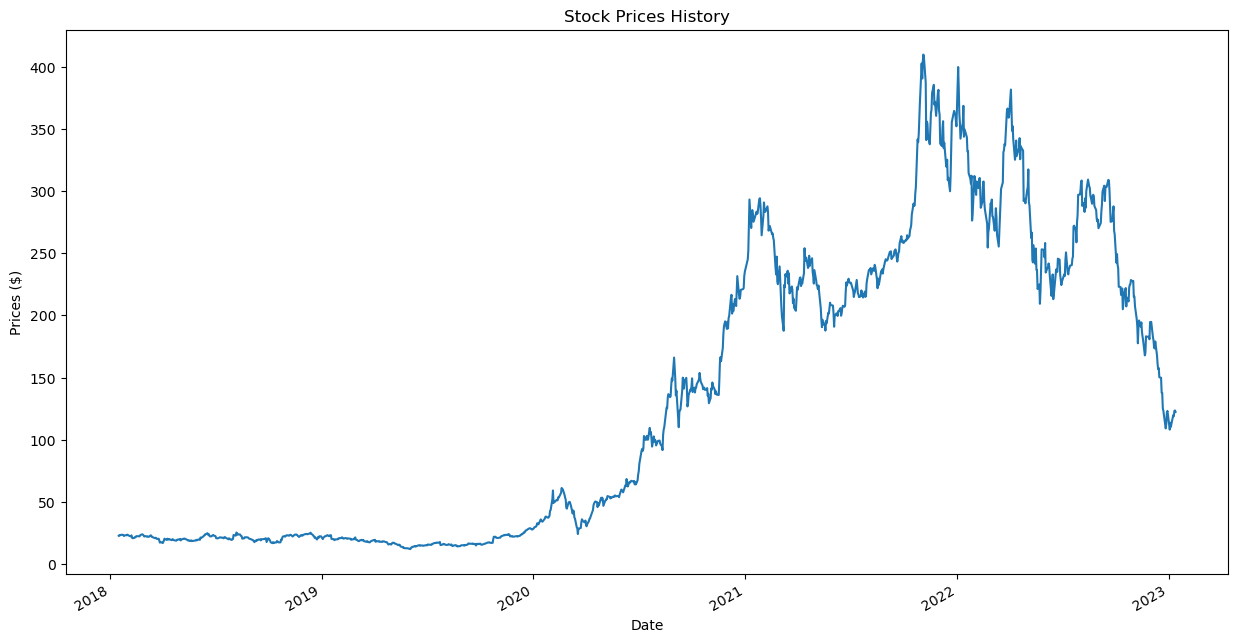

In [276]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [277]:
np.random.seed(12345)

In [58]:
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def metrics(y_true, y_pred):
    print('R2 Score:', r2_score(y_true=y_true, y_pred=y_pred))
    print('RMSE:', mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
    print('MAPE:', mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred))
    return r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)

In [279]:
def get_x_y_train_test(feature, test_size, window):
    np.random.seed(12345)
    close_prices = feature
    values = close_prices.values
    training_data_len = math.ceil(len(values) * (1 - test_size))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values.reshape(-1, 1))
    train_data = scaled_data[0: training_data_len, :]
    x_train = []
    y_train = []
    for i in range(window, len(train_data)):
        x_train.append(train_data[i - window:i])
        y_train.append(train_data[i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    test_data = scaled_data[training_data_len - window:]
    x_test = []
    y_test = values[training_data_len:]
    for i in range(window, len(test_data)):
        x_test.append(test_data[i - window:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #TODO способ подачи
    return scaler, x_test, x_train, y_test, y_train

In [55]:
def fit_actions(x_train, y_train, n_features=1):
    np.random.seed(12345)
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=False, input_shape=(x_train.shape[1], n_features)))

    model.add(layers.Dense(1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=15, epochs=100)
    return model

In [281]:
# smape = round(
#     np.mean(
#         np.abs(predictions - y_test) /
#         ((np.abs(predictions) + np.abs(y_test))/2)
#     )*100, 2
# )
# smape

In [51]:
# tmp = [[[0.58660634],
#         [0.59224231],
#         [0.59349007],
#         [0.88702102],
#         [0.87831163],
#         [0.82000074]]]
# my = model.predict(tmp)
# my

In [52]:
np.random.seed(12345)
scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(data_TSLA['close'],
                                                                                                      window=60,
                                                                                                      test_size=0.2)
model_per_day = fit_actions(x_train_per_day, y_train_per_day)
predictions_per_day = model_per_day.predict(x_test_per_day)
predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
r2_per_day, rmse_per_day, mape_per_day= metrics(y_true=y_test_per_day, y_pred=predictions_per_day)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
64/64 [==============================] - 2s 19ms/step - loss: 0.0087
Epoch 2/100
64/64 [==============================] - 1s 18ms/step - loss: 9.9027e-04
Epoch 3/100
64/64 [==============================] - 1s 20ms/step - loss: 9.6093e-04
Epoch 4/100
64/64 [==============================] - 1s 22ms/step - loss: 8.4224e-04
Epoch 5/100
64/64 [==============================] - 1s 22ms/step - loss: 8.8300e-04
Epoch 6/100
64/64 [======

Метрики посчитаны и записаны, теперь поиграемся с гранулярностью и обучим модель на данных по неделям.

In [53]:
data_TSLA.index

Index(['2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-22',
       '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29',
       ...
       '2022-12-30', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
       '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13'],
      dtype='object', name='Date', length=1259)

In [54]:
first_index = data_TSLA.index[0]
last_index = data_TSLA.index[len(data_TSLA) - 1]
new_data = data_TSLA.loc[first_index:last_index:7, ]
new_data

,open,high,low,close,adj close,volume
Date,,,,,,
2018-01-16,22.502666,23.000000,22.320000,22.670668,22.670668,97114500
2018-01-25,23.218000,23.280001,22.426666,22.509333,22.509333,101104500
2018-02-05,22.531334,22.964666,22.200001,22.208668,22.208668,66961500
2018-02-14,21.389334,21.744667,21.234667,21.487333,21.487333,59260500
2018-02-26,23.566668,23.933332,23.490667,23.827999,23.827999,65100000
...,...,...,...,...,...,...
2022-11-25,185.059998,185.199997,180.630005,182.860001,182.860001,50672700
2022-12-06,181.220001,183.649994,175.330002,179.820007,179.820007,92150800
2022-12-15,153.440002,160.929993,153.279999,157.669998,157.669998,122334500


In [55]:

counter = 0
week = []
column_week = []
column_index = []

for i in range(len(data_TSLA)):
    counter += 1
    if counter > 7:
        counter = 1
        column_week.append(np.mean(week))
        column_index.append(str(data_TSLA.index[i - 7]) + '---' + str(data_TSLA.index[i - 1]))
        week = []
    week.append(data_TSLA.loc[data_TSLA.index[i], 'close'])
#TODO сделать индексы как я хотел (до и после) и обучить модель

data_per_week = pd.DataFrame({'close': column_week}, index=column_index)

display(data_per_week.head(20))
# data_per_week_1 = data.close.rolling(7).mean()


,close
2018-01-16---2018-01-24,23.162381
2018-01-25---2018-02-02,23.077619
2018-02-05---2018-02-13,21.687048
2018-02-14---2018-02-23,22.458666
2018-02-26---2018-03-06,22.657809
2018-03-07---2018-03-15,22.172857
2018-03-16---2018-03-26,20.731523
2018-03-27---2018-04-05,18.245333
2018-04-06---2018-04-16,19.811619
2018-04-17---2018-04-25,19.227428


Теперь обучим на неделях. Передадим в *get_x_y_train_test* признак, где собранны данные по неделям. Протестируем также на неделях.

In [56]:
scaler_per_week, x_test_per_week, x_train_per_week, y_test_per_week, y_train_per_week = get_x_y_train_test(
    data_per_week['close'], window=20, test_size=0.2)
model_per_week = fit_actions(x_train_per_week, y_train_per_week)
predictions_per_week = model_per_week.predict(x_test_per_week)
predictions_per_week = scaler_per_week.inverse_transform(predictions_per_week)

r2_per_week, rmse_per_week, mape_per_week = metrics(y_true=y_test_per_week, y_pred=predictions_per_week)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 1s 9ms/step - loss: 0.1191
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 6/100
9/9 [==============================] - 0s 7m

Теперь же протестируем данные по дням на нашей модели, которую обучали на недельных данных.

In [57]:
predictions_per_week_on_day = model_per_week.predict(x_test_per_day)
predictions_per_week_on_day = scaler_per_week.inverse_transform(predictions_per_week_on_day)
r2_per_week_on_day, rmse_per_week_on_day, mape_per_week_on_day = metrics(y_true=y_test_per_day, y_pred=predictions_per_week_on_day)

8/8 [==============================] - 0s 11ms/step
R2 Score: 0.9066625153123063
RMSE: 18.462507999652725
MAPE: 0.06114075861660409


Получилось, что в не зависимости на какой грануляции мы обучаем модель подавать на вход по дням дает намного больше точности.

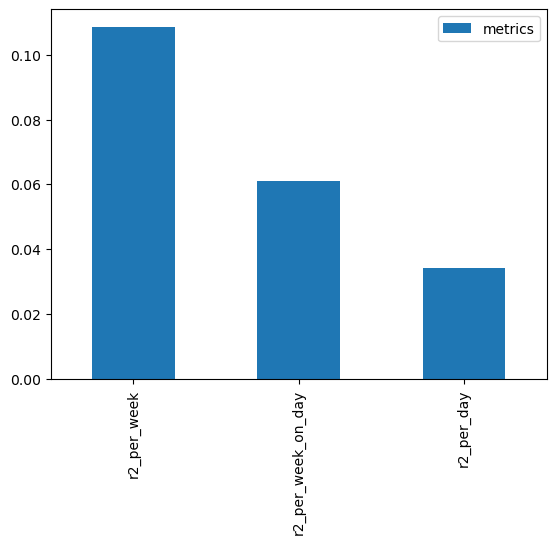

In [58]:
metrics_bar = pd.DataFrame({'metrics': [mape_per_week, mape_per_week_on_day, mape_per_day]},
                       index=['r2_per_week', 'r2_per_week_on_day', 'r2_per_day'])
metrics_bar.plot(kind='bar');

Проведем эксперимент: Часто бывает такое, что на условном начале периода цена акций была в районе 20, как в случае с нашим датасетом, а в конце выборки около 180, то бишь цены намного сильно выросли. Найдем такую точку в датасете, где наблюдается сильная разница между акциями до и после и будем обучать на более "высоких" или же более "низких" ценах, чтобы точнее предсказать следующие дни.

In [59]:
data_TSLA.tail(100)

,open,high,low,close,adj close,volume
Date,,,,,,
2022-08-23,291.453339,298.826660,287.923340,296.453339,296.453339,63984900
2022-08-24,297.563324,303.646667,296.500000,297.096680,297.096680,57259800
2022-08-25,302.359985,302.959991,291.600006,296.070007,296.070007,53230000
2022-08-26,297.429993,302.000000,287.470001,288.089996,288.089996,57163900
2022-08-29,282.829987,287.739990,280.700012,284.820007,284.820007,41864700
...,...,...,...,...,...,...
2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000
2023-01-10,121.070000,122.760002,114.919998,118.849998,118.849998,167642500
2023-01-11,122.089996,125.949997,120.510002,123.220001,123.220001,183810800


In [60]:
print(len(data_TSLA))
for i in range(len(data_TSLA)):
    print(data_TSLA.loc[data_TSLA.index[len(data_TSLA) - 1 - i], :])

1259
open         1.165500e+02
high         1.226300e+02
low          1.156000e+02
close        1.224000e+02
adj close    1.224000e+02
volume       1.804393e+08
Name: 2023-01-13, dtype: float64
open         1.225600e+02
high         1.241300e+02
low          1.170000e+02
close        1.235600e+02
adj close    1.235600e+02
volume       1.694009e+08
Name: 2023-01-12, dtype: float64
open         1.220900e+02
high         1.259500e+02
low          1.205100e+02
close        1.232200e+02
adj close    1.232200e+02
volume       1.838108e+08
Name: 2023-01-11, dtype: float64
open         1.210700e+02
high         1.227600e+02
low          1.149200e+02
close        1.188500e+02
adj close    1.188500e+02
volume       1.676425e+08
Name: 2023-01-10, dtype: float64
open         1.189600e+02
high         1.235200e+02
low          1.171100e+02
close        1.197700e+02
adj close    1.197700e+02
volume       1.902840e+08
Name: 2023-01-09, dtype: float64
open         1.030000e+02
high         1.143900e+0

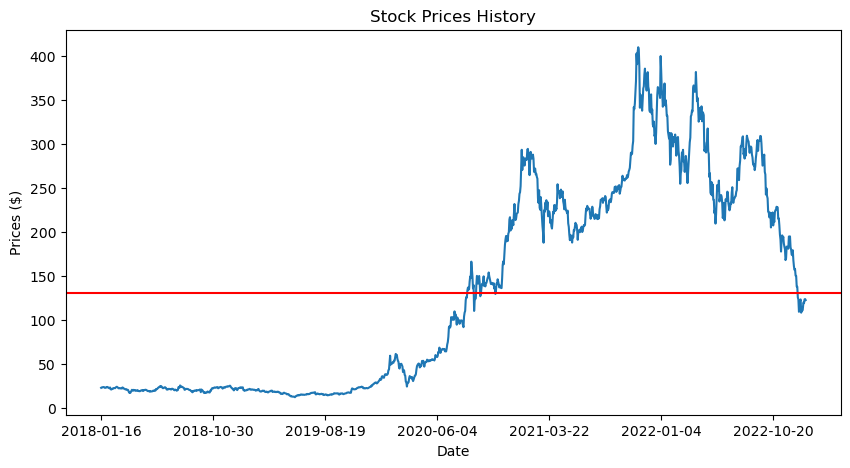

In [61]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');
plt.axhline(130, color='red');

In [55]:
print('Средняя за весь период:', data_TSLA['close'].mean())

for i in np.unique(data_TSLA.index):

print('Средняя за 2021 год:', data_TSLA.loc['2021-01-01':'2021-12-30', 'close'].mean())
print('В первый день 2021:', data_TSLA.loc['2021-01-01':, 'close'][0])

Средняя за весь период: 132.46519670452744
Средняя за 2021 год: 259.63058462549805
В первый день 2021: 243.256668


Данных для обучения достаточно.

Кол-во дней для обучения: 583


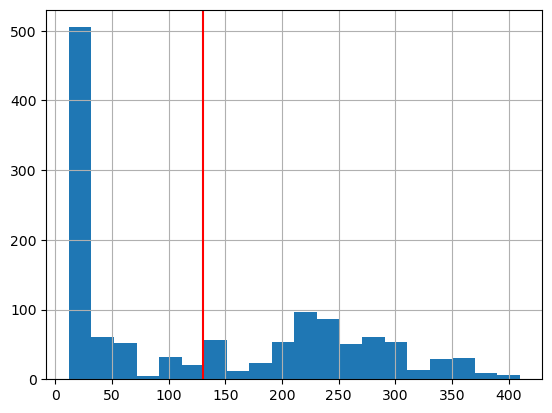

In [62]:
data_TSLA.close.hist(bins=20)
plt.axvline(130, color='red');
print("Кол-во дней для обучения:", len(data_TSLA[data_TSLA['close'] > 130]))

In [63]:
scaler_threshold_TSLA, x_test_threshold_TSLA, x_train_threshold_TSLA, y_test_threshold_TSLA, y_train_threshold_TSLA = get_x_y_train_test(
    data_TSLA.loc['2020-08-20':, 'close'], window=60, test_size=0.2)
model_threshold_TSLA = fit_actions(x_train_threshold_TSLA, y_train_threshold_TSLA)
predictions_threshold_TSLA = model_threshold_TSLA.predict(x_test_threshold_TSLA)
predictions_threshold_TSLA = scaler_threshold_TSLA.inverse_transform(predictions_threshold_TSLA)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100)               40800     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 2s 19ms/step - loss: 0.0597
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0054
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0043
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0042
Epoch 6/100
29/29 [======================

In [64]:
r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_TSLA, y_pred=predictions_threshold_TSLA)

R2 Score: 0.9777481568392157
RMSE: 9.36795515748167
MAPE: 0.03846415234225023


Подведем итоги:
- Обучая LSTM на всей выборке по дням и проверяя её на тех же днях метрики выглядят следующим образом:
- - R2 Score: 0.9382207802689864
- - RMSE: 12.518304890459328
- - MAPE: 0.0355177825338899
- Обучая LSTM на всей выборке разбив данные по неделям и проверяя еще на неделях метрики выглядит следующим образом:
- - R2 Score: 0.6477799255148751
- - RMSE: 28.496792117897996
- - MAPE: 0.08916431002672084
- Обучая LSTM на всей выборке разбив данные по неделям и проверяя их на ДНЯХ метрики выглядят следующим образом:
- - R2 Score: 0.8988059441755808
- - RMSE: 16.02144992417443
- - MAPE: 0.04663171922193334
- Обучая LSTM на ЧАСТИЧНОЙ выборке разбив данные по днях и проверяя их на днях метрики выглядят следующим образом:
- - R2 Score: 0.9528368878671135
- - RMSE: 8.898311722896876
- - MAPE: 0.029604843476777658


Таким образом получилось, что лучше всего подавать данные по дням и именно частично, то бишь передавая более свежие данные, которые более точно характеризуют временной отрезок цен акций.

In [80]:
data_APPL = pd.read_csv('../datasets/AAPL.csv', index_col=[0], parse_dates=[0])
data_APPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-16,44.474998,44.847500,44.035000,44.047501,41.884754,118263600
2018-01-17,44.037498,44.812500,43.767502,44.775002,42.576534,137547200
2018-01-18,44.842499,45.025002,44.562500,44.814999,42.614574,124773600
2018-01-19,44.652500,44.895000,44.352501,44.615002,42.424400,129700400
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.077309,108434400
...,...,...,...,...,...,...
2023-01-09,130.470001,133.410004,129.889999,130.149994,130.149994,70790800
2023-01-10,130.259995,131.259995,128.119995,130.729996,130.729996,63896200
2023-01-11,131.250000,133.509995,130.460007,133.490005,133.490005,69458900


In [81]:
data_APPL.columns = data_APPL.columns.str.lower()
data_APPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-16 to 2023-01-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1259 non-null   float64
 1   high       1259 non-null   float64
 2   low        1259 non-null   float64
 3   close      1259 non-null   float64
 4   adj close  1259 non-null   float64
 5   volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Text(0, 0.5, 'Prices ($)')

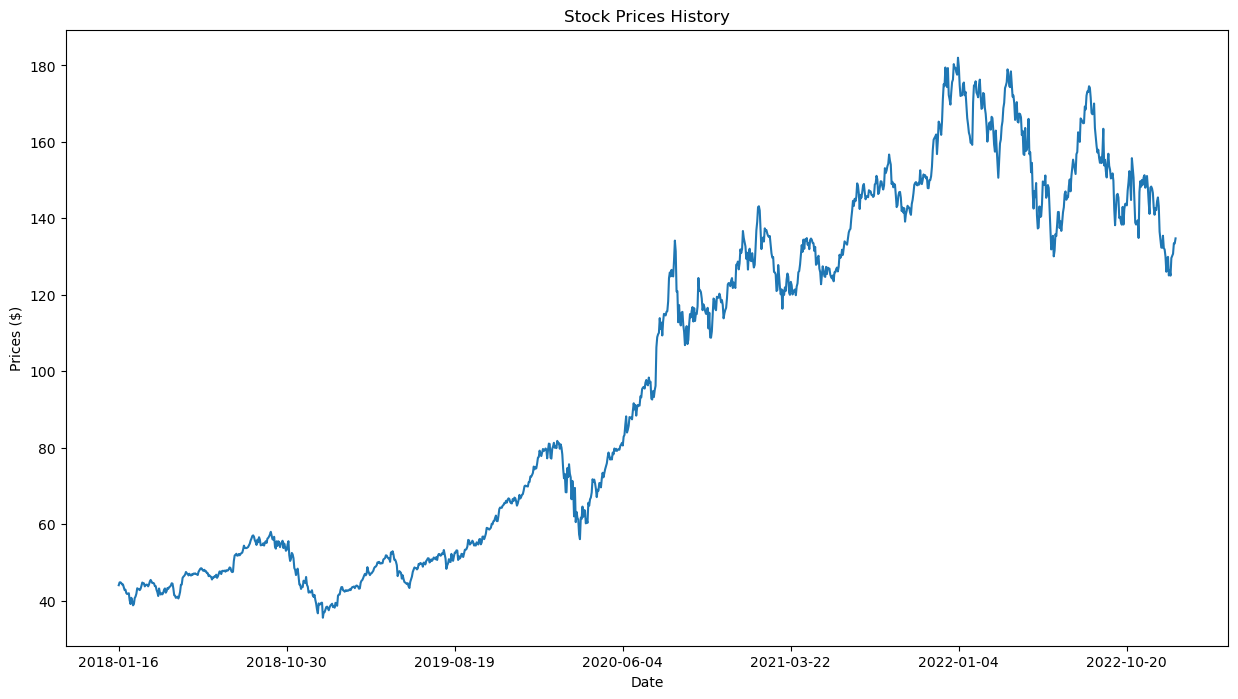

In [67]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

Иcходя из предыдущий вычислений, обучать будем не на всем датасете, а на частичном.

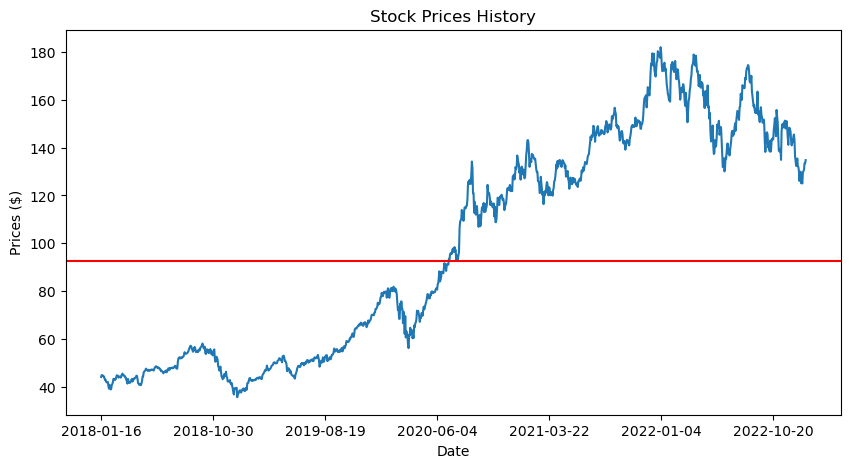

In [68]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');
plt.axhline(92.50, color='red');

In [69]:
scaler_threshold_APPL, x_test_threshold_APPL, x_train_threshold_APPL, y_test_threshold_APPL, y_train_threshold_APPL = get_x_y_train_test(
    data_APPL.loc['2020-07-06':, 'close'], window=60, test_size=0.2)
model_threshold_APPL = fit_actions(x_train_threshold_APPL, y_train_threshold_APPL)
predictions_threshold_APPL = model_threshold_APPL.predict(x_test_threshold_APPL)
predictions_threshold_APPL = scaler_threshold_APPL.inverse_transform(predictions_threshold_APPL)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100)               40800     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 0.0748
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0057
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0039
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0036
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0033
Epoch 6/100
31/31 [=====================

In [70]:
r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_APPL, y_pred=predictions_threshold_APPL)

R2 Score: 0.9149190279731665
RMSE: 3.4478957290527457
MAPE: 0.018361006295483373


In [71]:
# total_data = pd.concat([data_TSLA.loc['2020-08-20':, 'close']] + [data_TSLA.loc['2020-08-20':, 'close']])
# total_data

In [72]:
# scaler_threshold_total, x_test_threshold_total, x_train_threshold_total, y_test_threshold_total, y_train_threshold_total = get_x_y_train_test(
#     total_data, window=60, test_size=0.2)
# model_threshold_total = fit_actions(x_train_threshold_total, y_train_threshold_total)
# predictions_threshold_total = model_threshold_total.predict(x_test_threshold_total)
# predictions_threshold_total = scaler_threshold_total.inverse_transform(predictions_threshold_total)

In [73]:
# r2_threshold, rmse_threshold, mape_threshold = metrics(y_true=y_test_threshold_total, y_pred=predictions_threshold_total)

Теперь попробуем обучить Multivariate LSTM. Добавим к акциям Теслы еще и информацию об акциях Apple. Однако наш предыдущий метод, который позволял нам разбивать данные *get_x_y_train_test*, так как он предназначался для одномерных массивов, а теперь у нас их целых два! Создадим новый метод.

In [282]:
def split_sequence(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences) - 1:
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

И подготовим данные для их дальнейшей передачи в метод.

In [292]:
tesla = data_TSLA['close'].values
apple = data_APPL['close'].values
out_tesla = data_TSLA['close'].shift(-1).values

tesla = tesla.reshape((len(tesla), 1))
apple = apple.reshape((len(apple), 1))
out_tesla = out_tesla.reshape((len(out_tesla), 1))

# print(tesla.shape)
# print(apple.shape)
# print(out_tesla)

dataset = np.hstack((tesla, apple, out_tesla))
pd.DataFrame(dataset)

,0,1,2
0,22.670668,44.047501,23.143999
1,23.143999,44.775002,22.971333
2,22.971333,44.814999,23.334667
3,23.334667,44.615002,23.437332
4,23.437332,44.250000,23.519333
...,...,...,...
1254,119.769997,130.149994,118.849998
1255,118.849998,130.729996,123.220001
1256,123.220001,133.490005,123.559998
1257,123.559998,133.410004,122.400002


Укажем временное окно и посмотрим как теперь выглядят наши данные. Можем заметить, что действительно - 60 дней теслы и 60 дней эппл теперь указывают на 61 день теслы.

In [293]:
n_steps = 60
X, y = split_sequence(dataset, n_steps)
n_features = X.shape[2]
#TODO global model одну для разных компаний.
for i in range(len(X)):
    print(X[i], y[i])

[[22.670668 44.047501]
 [23.143999 44.775002]
 [22.971333 44.814999]
 [23.334667 44.615002]
 [23.437332 44.25    ]] 23.519333
[[23.143999 44.775002]
 [22.971333 44.814999]
 [23.334667 44.615002]
 [23.437332 44.25    ]
 [23.519333 44.259998]] 23.059334
[[22.971333 44.814999]
 [23.334667 44.615002]
 [23.437332 44.25    ]
 [23.519333 44.259998]
 [23.059334 43.555   ]] 22.509333
[[23.334667 44.615002]
 [23.437332 44.25    ]
 [23.519333 44.259998]
 [23.059334 43.555   ]
 [22.509333 42.7775  ]] 22.856667
[[23.437332 44.25    ]
 [23.519333 44.259998]
 [23.059334 43.555   ]
 [22.509333 42.7775  ]
 [22.856667 42.877499]] 23.302
[[23.519333 44.259998]
 [23.059334 43.555   ]
 [22.509333 42.7775  ]
 [22.856667 42.877499]
 [23.302    41.990002]] 23.054667
[[23.059334 43.555   ]
 [22.509333 42.7775  ]
 [22.856667 42.877499]
 [23.302    41.990002]
 [23.054667 41.7425  ]] 23.620667
[[22.509333 42.7775  ]
 [22.856667 42.877499]
 [23.302    41.990002]
 [23.054667 41.7425  ]
 [23.620667 41.857498]] 23.28

In [285]:
X.shape

(1199, 60, 2)

In [286]:
train_size = int(np.ceil(0.8 * len(X)))
test_size = int(len(X) - train_size)

features_train = X[:train_size]
target_train = y[:train_size]
features_test = X[test_size:]
target_test = y[test_size:]
target_train

array([ 19.605333,  20.022667,  19.414   ,  19.179333,  19.556667,
        20.005333,  19.349333,  18.891333,  18.897333,  18.712667,
        19.032   ,  19.605333,  19.593332,  19.994667,  20.076668,
        18.963333,  19.606001,  20.184668,  20.131332,  20.456667,
        20.334667,  20.070667,  19.464666,  18.945333,  19.098667,
        18.969334,  18.454666,  18.966   ,  18.334   ,  18.604668,
        18.523333,  18.59    ,  18.917334,  19.448   ,  18.982   ,
        19.454666,  19.782667,  19.408667,  21.299999,  21.072666,
        21.177334,  22.139999,  22.851334,  22.985332,  23.848   ,
        23.878   ,  24.722   ,  23.503332,  24.148001,  23.167334,
        22.242001,  22.200666,  22.799999,  22.966667,  23.328667,
        22.863333,  22.337999,  20.724001,  20.610666,  20.593332,
        21.233999,  21.497999,  21.264   ,  21.114   ,  21.257999,
        20.673332,  21.512667,  21.59    ,  21.348667,  20.905333,
        20.213333,  19.828667,  20.582666,  20.443333,  19.812

In [287]:
model_per_day = fit_actions(features_train, target_train, n_features)
predictions_per_day = model_per_day.predict(features_test)
# predictions_per_day = scaler.inverse_transform(predictions_per_day)
r2_per_day, rmse_per_day, mape_per_day= metrics(y_true=target_test, y_pred=predictions_per_day)

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 100)               41200     
                                                                 
 dense_60 (Dense)            (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
64/64 [==============================] - 2s 16ms/step - loss: 23448.9355
Epoch 2/100
64/64 [==============================] - 1s 16ms/step - loss: 20989.5801
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 19715.0625
Epoch 4/100
64/64 [==============================] - 1s 16ms/step - loss: 18748.8652
Epoch 5/100
64/64 [==============================] - 1s 17ms/step - loss: 17791.7422
Epoch 6/100
64/64 [=

R2 Score: 0.9679804522525206
RMSE: 10.813598653815808
MAPE: 0.03424645931778173
<b></b>
Это метрики обучения модели по дням Теслы. Можно заметить, что незначительно улучшился R2 score, а остальные стали хуже. Но не стоит забывать, что это практически никак не связанные компании, так что это была просто проверка LSTM на факт умения обращаться с двумя и более признаками для предсказания и она успешно справилась!

In [288]:
def sorocinTest(data, feature, window):
    needed_value = data[len(data) - window:][feature].median()
    print('need:', needed_value)
    closest_value = needed_value + 1
    closest_year = 0
    for year in np.unique(data.index.year)[0:len(np.unique(data.index.year)) - 2]:
        if abs(needed_value - data.loc[f'{year}-01-01':f'{year}-12-30', feature].median()) < closest_value:
            closest_year = year
            closest_value = abs(needed_value - data.loc[f'{year}-01-01':f'{year}-12-30', feature].median())
        print(f'Медиана за {year} год:', data.loc[f'{year}-01-01':f'{year}-12-30', feature].median())
        print()
    return closest_year

In [289]:
sorocinTest(data_TSLA, 'close', 60)

need: 180.00500449999998
Медиана за 2018 год: 21.177334

Медиана за 2019 год: 17.344667

Медиана за 2020 год: 77.609665

Медиана за 2021 год: 243.256668



2021

In [290]:
for year in np.unique(data_TSLA.index.year):
    iter_data = data_TSLA[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.1)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 100)               40800     
                                                                 
 dense_61 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 3s 19ms/step - loss: 0.0148
Epoch 2/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 3/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 4/100
72/72 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 5/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0011
Epoch 6/100
72/72 [=====================

(0.9808428693884789, 8.598679460280247, 0.03188947830661355)

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 100)               40800     
                                                                 
 dense_62 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 [==============================] - 2s 19ms/step - loss: 0.0223
Epoch 2/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 3/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 4/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0015
Epoch 5/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0014
Epoch 6/100
58/58 [=====================

(0.9809988951819131, 8.261923507628032, 0.033416027334076115)

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 100)               40800     
                                                                 
 dense_63 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
42/42 [==============================] - 2s 19ms/step - loss: 0.0308
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0022
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0021
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0021
Epoch 6/100
42/42 [=====================

(0.9573845006654385, 9.200906320704847, 0.04059341265474935)

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 100)               40800     
                                                                 
 dense_64 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 20ms/step - loss: 0.0398
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0051
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0047
Epoch 5/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0042
Epoch 6/100
27/27 [=====================

(0.9374719091726859, 8.373558114213992, 0.04459363431872387)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 100)               40800     
                                                                 
 dense_65 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 0.1133
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0120
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0062
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0056
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 6/100
12/12 [=====================

(0.4681517800681887, 16.34105626329169, 0.10970163587328186)

IndexError: tuple index out of range

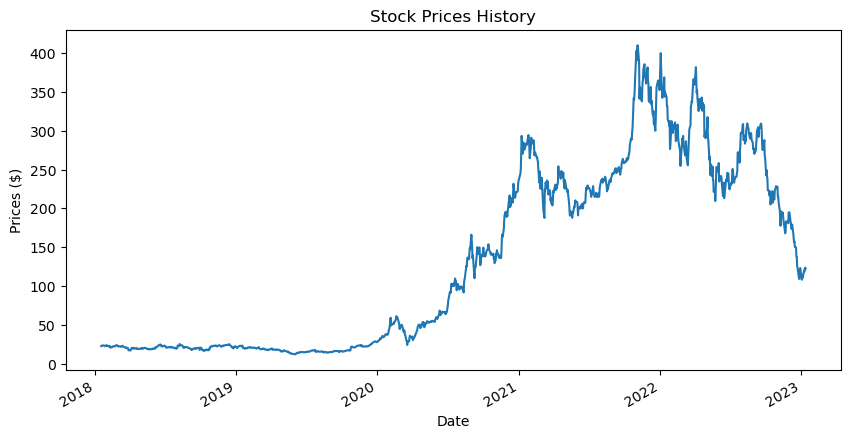

In [247]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA['close'].plot()
plt.xlabel('Date') #TODO посмотреть на фиксированый тест сайз
plt.ylabel('Prices ($)');

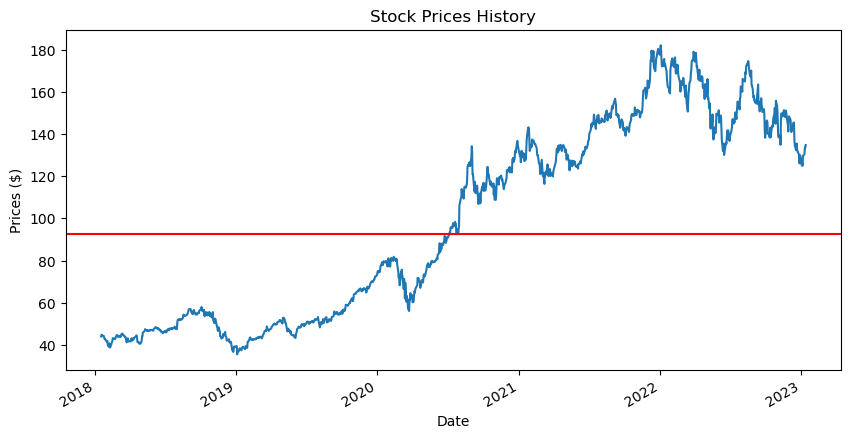

In [248]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_APPL['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)');

In [270]:
sorocinTest(data_APPL, 'close', 60)

need: 143.0600055
Медиана за 2018 год: 46.717499

Медиана за 2019 год: 50.724998

Медиана за 2020 год: 91.42124949999999

Медиана за 2021 год: 141.110001



2021

In [291]:
for year in np.unique(data_APPL.index.year):
    iter_data = data_APPL[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.1) #TODO test size za месяц

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))
#TODO рассказать идею - чем больше данных тем, чем меньше данных тем RMSE, а раньше думал, чем свежее данные

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 100)               40800     
                                                                 
 dense_66 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 3s 21ms/step - loss: 0.0231
Epoch 2/100
72/72 [==============================] - 1s 21ms/step - loss: 9.0629e-04
Epoch 3/100
72/72 [==============================] - 1s 20ms/step - loss: 8.3432e-04
Epoch 4/100
72/72 [==============================] - 1s 21ms/step - loss: 8.0048e-04
Epoch 5/100
72/72 [==============================] - 1s 20ms/step - loss: 7.6198e-04
Epoch 6/100
72/72 [=====

(0.9226720868373776, 3.3127720357930697, 0.01700225256391687)

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 100)               40800     
                                                                 
 dense_67 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 [==============================] - 2s 20ms/step - loss: 0.0182
Epoch 2/100
58/58 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 3/100
58/58 [==============================] - 1s 20ms/step - loss: 9.9378e-04
Epoch 4/100
58/58 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 5/100
58/58 [==============================] - 1s 20ms/step - loss: 8.2373e-04
Epoch 6/100
58/58 [=============

(0.8864628396715508, 3.385866313306692, 0.017856032372171773)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 100)               40800     
                                                                 
 dense_68 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
42/42 [==============================] - 2s 20ms/step - loss: 0.0362
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0023
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0017
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 6/100
42/42 [=====================

(0.7842993617153156, 3.5429413790676305, 0.019440537661621744)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 100)               40800     
                                                                 
 dense_69 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 19ms/step - loss: 0.0459
Epoch 2/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0068
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0055
Epoch 4/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0051
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0049
Epoch 6/100
27/27 [=====================

(0.7934324275824888, 3.678377201709779, 0.020071178976931718)

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 100)               40800     
                                                                 
 dense_70 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 0.1198
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0162
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0120
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0110
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0100
Epoch 6/100
12/12 [=====================

(0.2518137101077317, 5.1348077797365725, 0.032008364813420356)

IndexError: tuple index out of range

In [ ]:
print('Средняя за весь период:', data_TSLA['close'].mean())
print()

for year in np.unique(data_APPL.index.year):
    print(f'Медиана за {year} год:', data_APPL.loc[f'{year}-01-01':f'{year}-12-30', 'close'].median())
    print(f'В первый день {year}:', data_APPL.loc[f'{year}-01-01':, 'close'][0])
    print()
# data_TSLA.loc[f'{data_TSLA.index[len(data_TSLA.index) - 1]}', 'close']
data_APPL[len(data_APPL) - 60:]['close'].median()

In [296]:
data_META = pd.read_csv('../datasets/META.csv', index_col=[0], parse_dates=[0])
data_META.columns = data_META.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

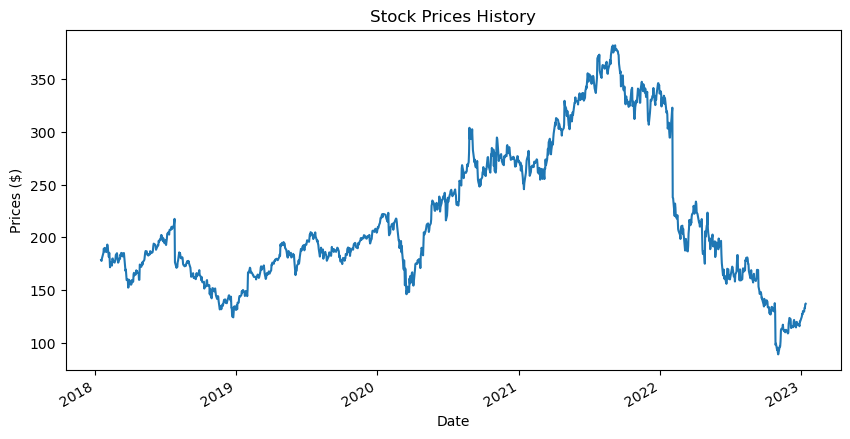

In [297]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_META['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_META, 'close', 60)

In [ ]:
for year in np.unique(data_META.index.year):
    iter_data = data_META[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [294]:
data_GOOG = pd.read_csv('../datasets/GOOG.csv', index_col=[0], parse_dates=[0])
data_GOOG.columns = data_GOOG.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

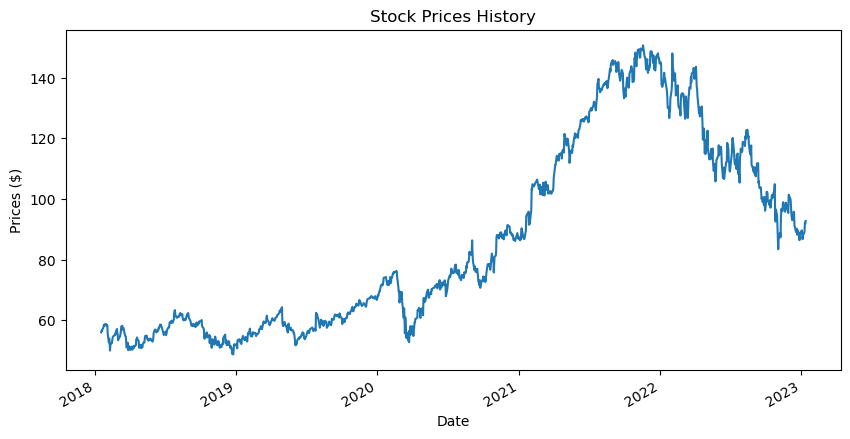

In [295]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_GOOG['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_GOOG, 'close', 100)

In [ ]:
for year in np.unique(data_GOOG.index.year):
    iter_data = data_GOOG[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [ ]:
iter_data = data_GOOG['2019-01-01':]
iter_data = iter_data['close']
scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                      window=60,
                                                                                                      test_size=0.2)

model_per_day = fit_actions(x_train_per_day, y_train_per_day)
predictions_per_day = model_per_day.predict(x_test_per_day)
predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))

In [ ]:
data_NFLX = pd.read_csv('../datasets/NFLX.csv', index_col=[0], parse_dates=[0])
data_NFLX.columns = data_NFLX.columns.str.lower()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_NFLX['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
sorocinTest(data_NFLX, 'close', 60)

In [ ]:
for year in np.unique(data_GOOG.index.year):
    iter_data = data_GOOG[f'{year}-01-01':]
    iter_data = iter_data['close']
    scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
                                                                                                          window=60,
                                                                                                          test_size=0.2)

    model_per_day = fit_actions(x_train_per_day, y_train_per_day)
    predictions_per_day = model_per_day.predict(x_test_per_day)
    predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
    print(year, 'ГОД')
    display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [48]:
def split_sequence_new(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [49]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv')
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

Text(0, 0.5, 'Prices ($)')

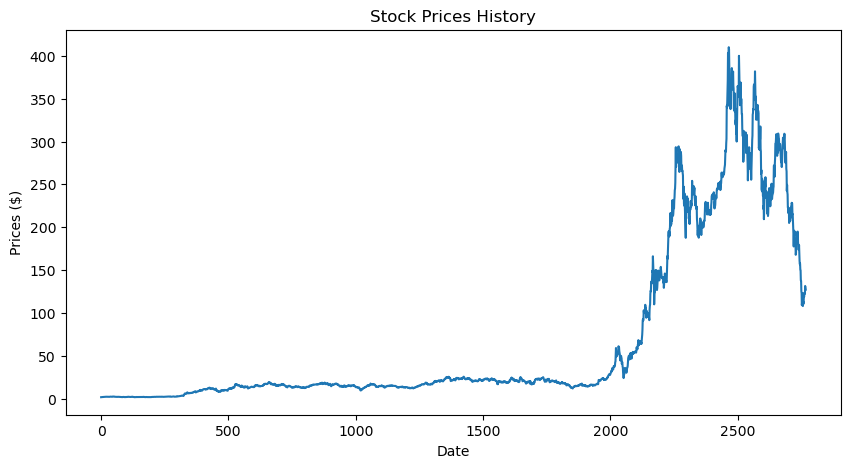

In [50]:
plt.figure(figsize=(10, 5))
plt.title('Stock Prices History')
data_TSLA_10_years['close'].plot()
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [51]:
n_steps = 60
X, y = split_sequence_new(data_TSLA_10_years['close'], n_steps)
data_TSLA_10_years['close'].shape

(2768,)

In [52]:
train_size = len(X) - 30
test_size = 30
print(train_size)
print(test_size)

features_train = X[:train_size]
target_train = y[:train_size]
features_test = X[len(X) - 30:]
target_test = y[len(X) - 30:]
print(features_train.shape)
print(features_test.shape)

2678
30
(2678, 60)
(30, 60)


In [53]:
# for year in np.unique(data_GOOG.index.year):
#     iter_data = data_GOOG[f'{year}-01-01':]
#     iter_data = iter_data['close']
#     scaler_per_day, x_test_per_day, x_train_per_day, y_test_per_day, y_train_per_day = get_x_y_train_test(iter_data,
#                                                                                                           window=60,
#                                                                                                           test_size=0.2)
#
#     model_per_day = fit_actions(x_train_per_day, y_train_per_day)
#     predictions_per_day = model_per_day.predict(x_test_per_day)
#     predictions_per_day = scaler_per_day.inverse_transform(predictions_per_day)
#     print(year, 'ГОД')
#     display(metrics(y_true=y_test_per_day, y_pred=predictions_per_day))


In [0]:
model_per_day = fit_actions(features_train, target_train)
predictions_per_day = model_per_day.predict(features_test)
# predictions_per_day = scaler.inverse_transform(predictions_per_day)

In [59]:
r2_per_day, rmse_per_day, mape_per_day= metrics(y_true=target_test, y_pred=predictions_per_day)

R2 Score: 0.7328696695846162
RMSE: 11.612445603289283
MAPE: 0.07827495128332139
